## EDA

Imports.

In [1]:
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore') # suppresses any warning messages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer, plot_roc_curve, roc_curve, precision_recall_fscore_support, precision_score, recall_score, roc_auc_score, f1_score

Load in data from csv, selecting only the relevant columns.

In [2]:
cols_to_use = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 'issue_d', 'dti', 'revol_bal', 
               'total_pymnt', 'loan_status']

df = pd.read_csv('loan.csv', usecols=cols_to_use, low_memory=False)

A quick glance at some metadata to understand the shape and types of the data. ```annual_inc``` has some missing values that will be handled after EDA which will help determine how to handle those cases.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   loan_amnt    887379 non-null  float64
 1   funded_amnt  887379 non-null  float64
 2   term         887379 non-null  object 
 3   int_rate     887379 non-null  float64
 4   grade        887379 non-null  object 
 5   annual_inc   887375 non-null  float64
 6   issue_d      887379 non-null  object 
 7   loan_status  887379 non-null  object 
 8   dti          887379 non-null  float64
 9   revol_bal    887379 non-null  float64
 10  total_pymnt  887379 non-null  float64
dtypes: float64(7), object(4)
memory usage: 74.5+ MB


Looking more closely at what the contents of each column are. The ```object``` datatype columns should be converted.

In [4]:
df.head(5)

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,Fully Paid,27.65,13648.0,5861.071414
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,Charged Off,1.00,1687.0,1008.710000
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,Fully Paid,8.72,2956.0,3003.653644
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,Fully Paid,20.00,5598.0,12226.302212
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,Current,17.94,27783.0,3242.170000


```issue_d``` should be a ```datetime```.

In [5]:
# The conversion to datetime sets each issue_d as the first day of the month - should not be an 
# issue given all issue_d values are being converted this way.
df['issue_d'] = pd.to_datetime(df['issue_d'])

df.head(5)

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
0,5000.0,5000.0,36 months,10.65,B,24000.0,2011-12-01,Fully Paid,27.65,13648.0,5861.071414
1,2500.0,2500.0,60 months,15.27,C,30000.0,2011-12-01,Charged Off,1.00,1687.0,1008.710000
2,2400.0,2400.0,36 months,15.96,C,12252.0,2011-12-01,Fully Paid,8.72,2956.0,3003.653644
3,10000.0,10000.0,36 months,13.49,C,49200.0,2011-12-01,Fully Paid,20.00,5598.0,12226.302212
4,3000.0,3000.0,60 months,12.69,B,80000.0,2011-12-01,Current,17.94,27783.0,3242.170000


Seeing what unique values the rest of the ```object``` datatype columns contain and confirming they can be converted to ```str```.

In [6]:
print('Unique values in columns of object datatype')
for col in df.select_dtypes(include=['object']):
    print(f'{df[col].name}: {df[col].unique()}')

Unique values in columns of object datatype
term: [' 36 months' ' 60 months']
grade: ['B' 'C' 'A' 'E' 'F' 'D' 'G']
loan_status: ['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off' 'Issued']


In [7]:
# Set type to str
for col in df.select_dtypes(include=['object']):
    df[col] = df[col].astype('str')
    
df.dtypes

loan_amnt             float64
funded_amnt           float64
term                   object
int_rate              float64
grade                  object
annual_inc            float64
issue_d        datetime64[ns]
loan_status            object
dti                   float64
revol_bal             float64
total_pymnt           float64
dtype: object

Summary statistics by column. Will explore further later in this notebook.

In [8]:
df.describe(include='all')

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
count,887379.000000,887379.000000,887379,887379.000000,887379,8.873750e+05,887379,887379,887379.000000,8.873790e+05,887379.000000
unique,NaN,NaN,2,NaN,7,NaN,103,10,NaN,NaN,NaN
top,NaN,NaN,36 months,NaN,B,NaN,2015-10-01 00:00:00,Current,NaN,NaN,NaN
freq,NaN,NaN,621125,NaN,254535,NaN,48631,601779,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2015-12-01 00:00:00,NaN,NaN,NaN,NaN
mean,14755.264605,14741.877625,NaN,13.246740,NaN,7.502759e+04,NaN,NaN,18.157039,1.692079e+04,7558.826684
std,8435.455601,8429.897657,NaN,4.381867,NaN,6.469830e+04,NaN,NaN,17.190626,2.242679e+04,7871.243336
min,500.000000,500.000000,NaN,5.320000,NaN,0.000000e+00,NaN,NaN,0.000000,0.000000e+00,0.000000
25%,8000.000000,8000.000000,NaN,9.990000,NaN,4.500000e+04,NaN,NaN,11.910000,6.443000e+03,1914.590000


In [9]:
# Wrapper to consolidate repeated code
# Will plot a histogram of each column with its density overlayed. Will also output some summary statistics.
def eda(data, title_opt=None):
    
    plt.figure(figsize=(12,7))
    
    # numeric columns
    if data.dtype == 'float64':
        # histogram with count
        ax = sns.distplot(data, kde=False, 
                          hist_kws={'color':'white'})
        ax.set(ylabel='Count', xlabel=f'{data.name if title_opt is None else title_opt}')
        
        # density plot to get a smoother distribution
        ax2 = plt.twinx()
        ax2 = sns.distplot(data, ax=ax2, 
                           hist_kws={'edgecolor':'black'},
                           kde_kws={'color':'darkblue'})
        ax2.set_ylabel('Density')
        
    # non-numeric columns
    else:
        ax = sns.countplot(x=data, order=sorted(data.unique()), palette='ch:s=.25,rot=-.25')
        ax.set(ylabel='Count')
        plt.xticks(rotation=90)
        
        # hack to not have all the x tick labels get jumbled up
        if data.dtype == 'datetime64[ns]':
            for i, label in enumerate(ax.get_xticklabels()):
                if i % 6 == 0:
                    label.set_visible(True)
                else:
                    label.set_visible(False)
        
    plt.title(data.name if title_opt is None else title_opt)
    
    # summary statistics
    print(data.describe(include='all'))

```loan_amnt``` has a slightly uniform distribution with a minor right skew. There seems to be a cap in loan amounts that one can apply for at \\$35,000. An interesting aspect of this distribution is that there are clusters at certain loan amounts (i.e. \\$10k, \\$15k, and \\$20k). This likely reflects how borrowers and lenders transact in whole increments (i.e. \\$2.5k, \\$5k, \\$10k).

count    887379.000000
mean      14755.264605
std        8435.455601
min         500.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64


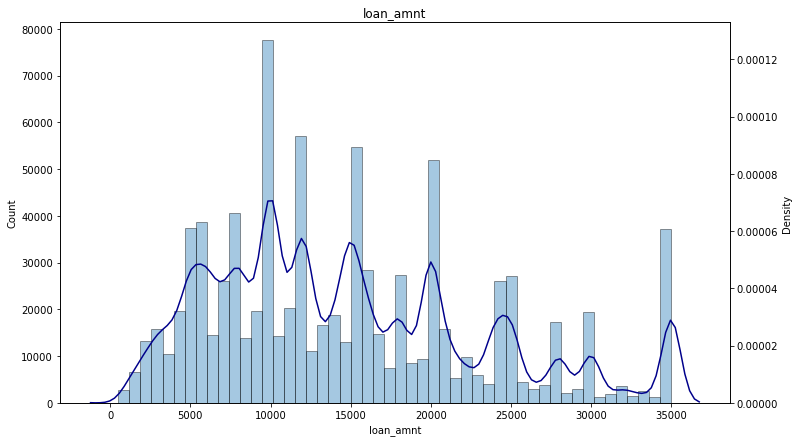

In [10]:
eda(df['loan_amnt'])

```funded_amnt``` very closely matches ```loan_amnt```. The minor differences are discerned through the summary statistics.

count    887379.000000
mean      14741.877625
std        8429.897657
min         500.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: funded_amnt, dtype: float64


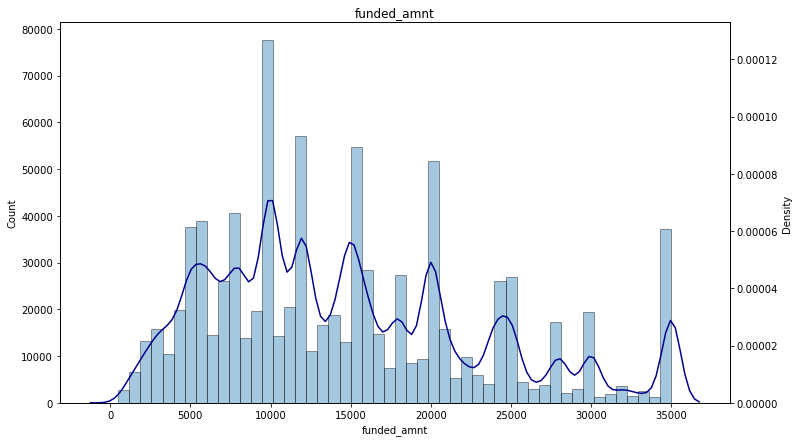

In [11]:
eda(df['funded_amnt'])

There are only two possible ```term``` values for loans, with most being ```36 months```.

count         887379
unique             2
top        36 months
freq          621125
Name: term, dtype: object


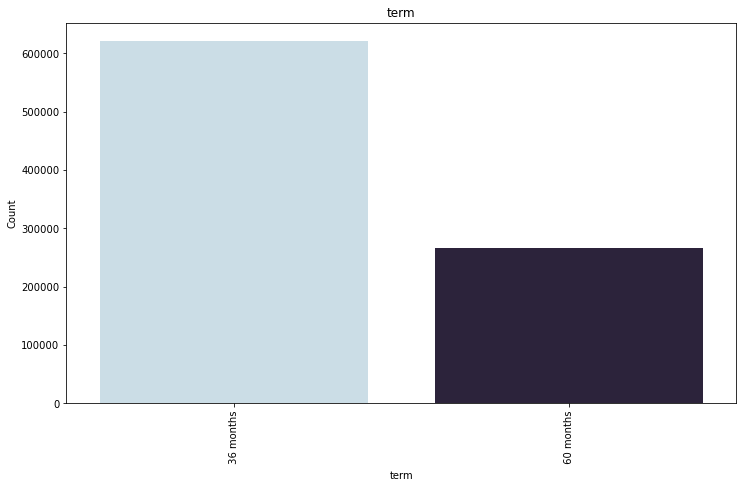

In [12]:
eda(df['term'])

```int_rate``` has a mostly bell shaped distribution with a bit of a right tail.

count    887379.000000
mean         13.246740
std           4.381867
min           5.320000
25%           9.990000
50%          12.990000
75%          16.200000
max          28.990000
Name: int_rate, dtype: float64


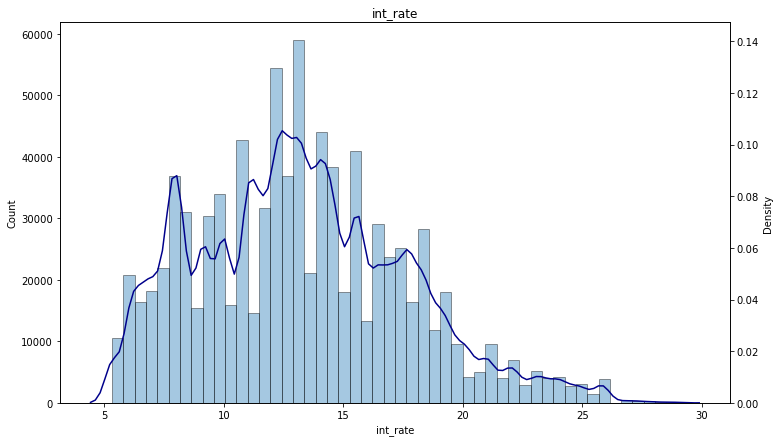

In [13]:
eda(df['int_rate'])

There are 7 loan grades. B and C grades are the most common and there are only a handful of G grade loans.

count     887379
unique         7
top            B
freq      254535
Name: grade, dtype: object


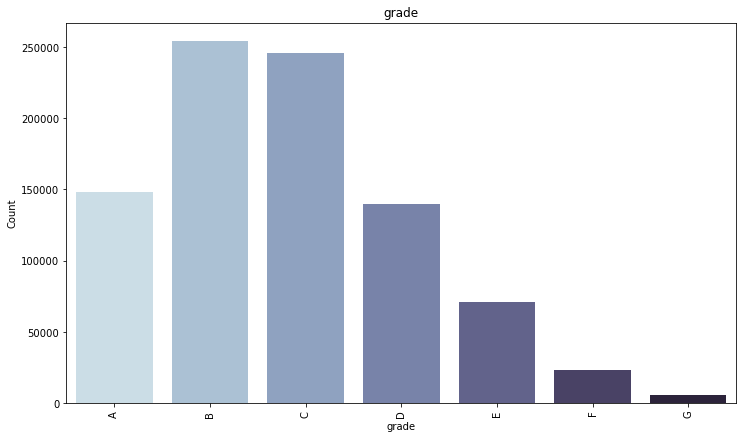

In [14]:
eda(df['grade'])

As usual, ```annual_inc``` is heavily right skewed as expected.

count    8.873750e+05
mean     7.502759e+04
std      6.469830e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64


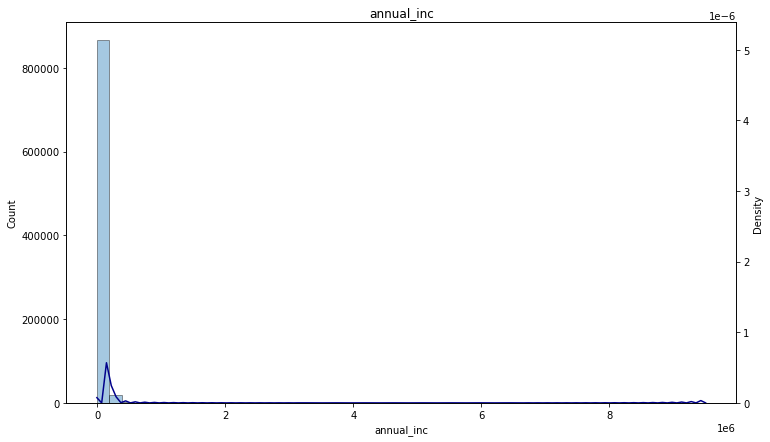

In [15]:
eda(df['annual_inc'])

Given ```annual_inc``` doesn't have a large proportion of 0's, I'll apply a variation of the Box-Cox transformation to it to get a nicer visualization. I specifically transform it as ```log(annual_inc + 1)``` so that 0 still maps to 0. The resulting distribution is log-normal.

In [16]:
print(f'Proportion of rows with annual_inc = 0: {df[df.annual_inc == 0].annual_inc.count() / df.shape[0]}')

Proportion of rows with annual_inc = 0: 2.2538284092817163e-06


count    887375.000000
mean         11.075042
std           0.528560
min           0.000000
25%          10.714440
50%          11.082158
75%          11.407576
max          16.066802
Name: annual_inc, dtype: float64


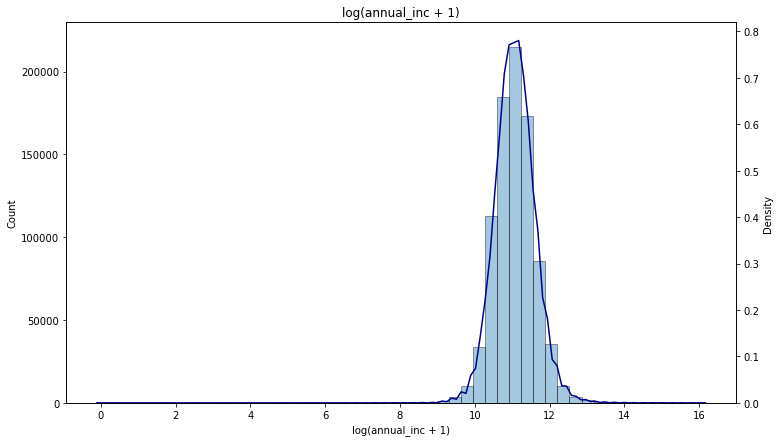

In [17]:
eda(np.log(df['annual_inc'].map(lambda x: x + 1)), title_opt='log(annual_inc + 1)')

The number of loans issued grows substantially over time. There doesn't appear to be any apparent seasonality although since mid-2014, the variation in number of loans issued by date does increase a lot.

count                  887379
unique                    103
top       2015-10-01 00:00:00
freq                    48631
first     2007-06-01 00:00:00
last      2015-12-01 00:00:00
Name: issue_d, dtype: object


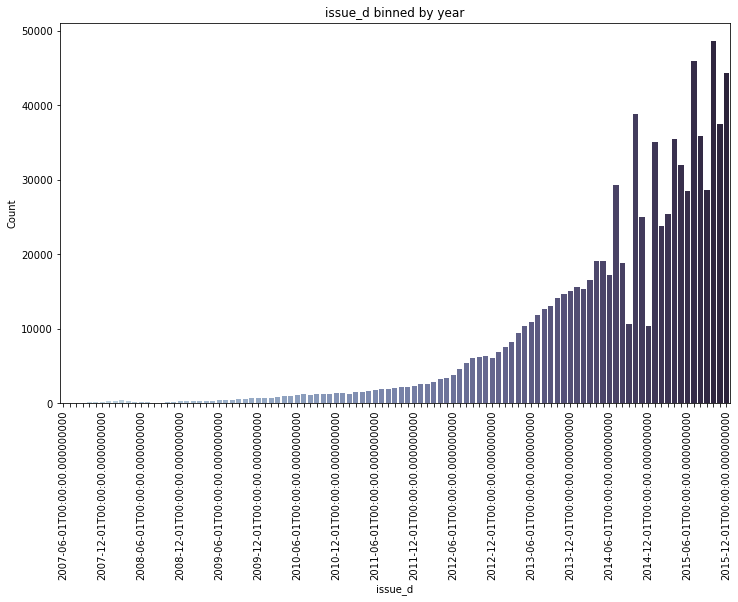

In [18]:
eda(df['issue_d'], title_opt='issue_d binned by year')

```dti``` has a heavy right skew. The range between the 75 percentile and the max is orders of magnitude larger than the range between the 0th percentile and the 75th percentile. For the same reasons as ```annual_inc```, I apply the same transformation. The resulting distribution is largely log-normal with a sharp dropoff after +1 standard deviations from the mean and a long tail.

count    887379.000000
mean         18.157039
std          17.190626
min           0.000000
25%          11.910000
50%          17.650000
75%          23.950000
max        9999.000000
Name: dti, dtype: float64


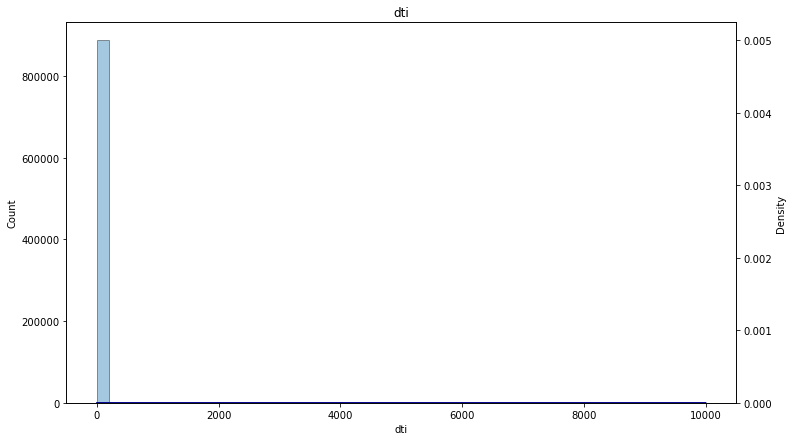

In [19]:
eda(df['dti'])

In [20]:
print(f'Proportion of rows with dti = 0: {df[df.dti == 0].dti.count() / df.shape[0]}')

Proportion of rows with dti = 0: 0.000508238306293027


count    887379.000000
mean          2.832395
std           0.535684
min           0.000000
25%           2.558002
50%           2.925846
75%           3.216874
max           9.210340
Name: dti, dtype: float64


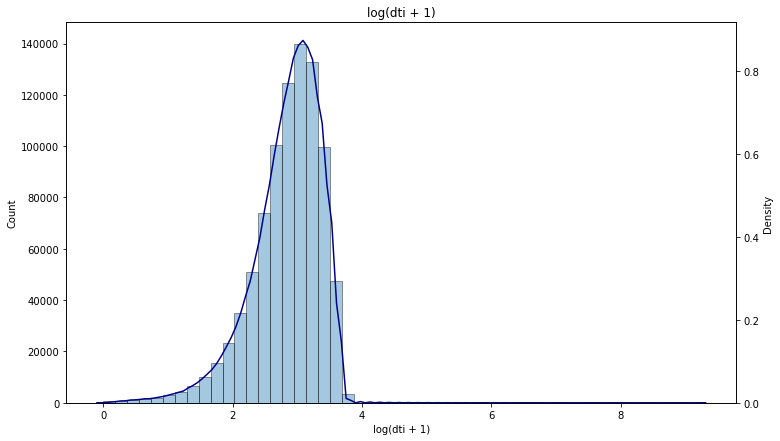

In [21]:
eda(np.log(df['dti'].map(lambda x: x + 1)), title_opt='log(dti + 1)')

```revol_bal``` is also heavily right skewed and log-normal. There is a larger number of 0's but not enough that I would want to apply additional transformations.

count    8.873790e+05
mean     1.692079e+04
std      2.242679e+04
min      0.000000e+00
25%      6.443000e+03
50%      1.187500e+04
75%      2.082900e+04
max      2.904836e+06
Name: revol_bal, dtype: float64


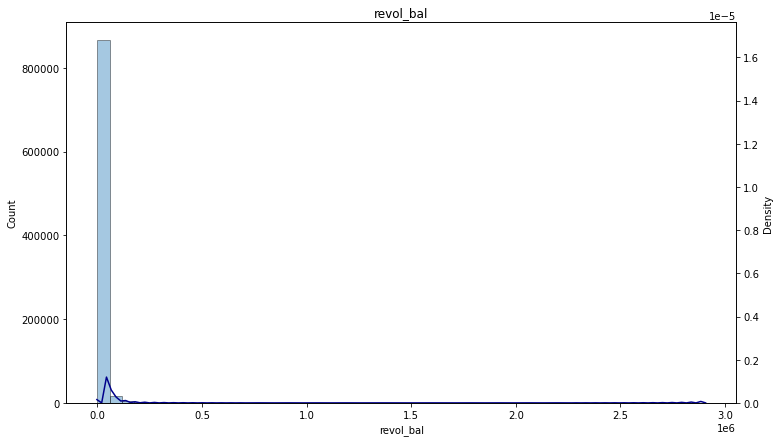

In [22]:
eda(df['revol_bal'])

In [23]:
print(f'Proportion of rows with revol_bal = 0: {round(df[df.revol_bal == 0].revol_bal.count() / df.shape[0], 4)}')

Proportion of rows with revol_bal = 0: 0.0038


count    887379.000000
mean          9.275082
std           1.148613
min           0.000000
25%           8.770905
50%           9.382275
75%           9.944150
max          14.881888
Name: revol_bal, dtype: float64


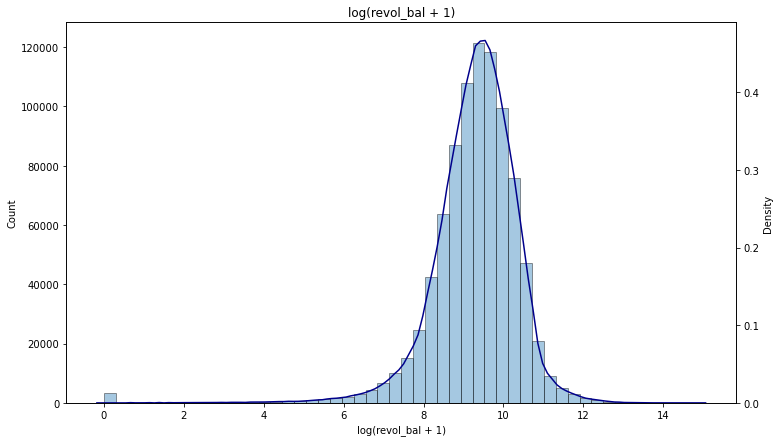

In [24]:
eda(np.log(df['revol_bal'].map(lambda x: x + 1)), title_opt='log(revol_bal + 1)')

```total_pymnt``` is also right skewed and log-normal (but with a slight left skew). There is a larger number of 0's but not enough that I would want to apply additional transformations.

count    887379.000000
mean       7558.826684
std        7871.243336
min           0.000000
25%        1914.590000
50%        4894.999117
75%       10616.814231
max       57777.579870
Name: total_pymnt, dtype: float64


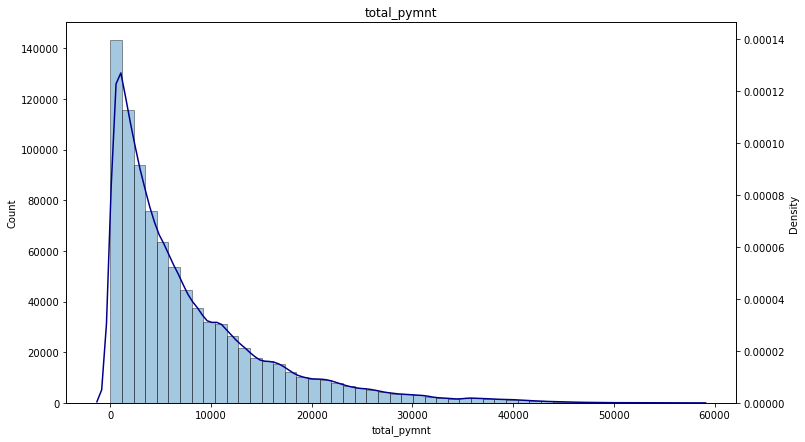

In [25]:
eda(df['total_pymnt'])

In [26]:
print(f'Proportion of rows with total_pymnt = 0: {round(df[df.total_pymnt == 0].total_pymnt.count() / df.shape[0], 3)}')

Proportion of rows with total_pymnt = 0: 0.02


count    887379.000000
mean          8.216105
std           1.665171
min           0.000000
25%           7.557781
50%           8.496174
75%           9.270288
max          10.964373
Name: total_pymnt, dtype: float64


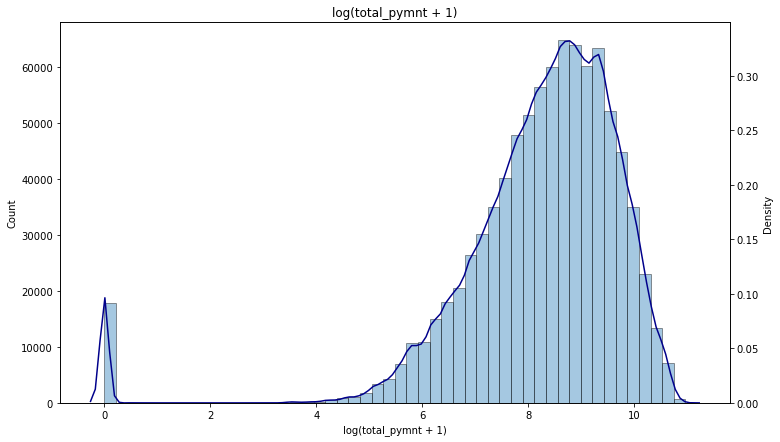

In [27]:
eda(np.log(df['total_pymnt'].map(lambda x: x + 1)), title_opt='log(total_pymnt + 1)')

```loan_status``` has multiple categories, with the most common being ```Current``` followed by ```Fully Paid```.

count      887379
unique         10
top       Current
freq       601779
Name: loan_status, dtype: object


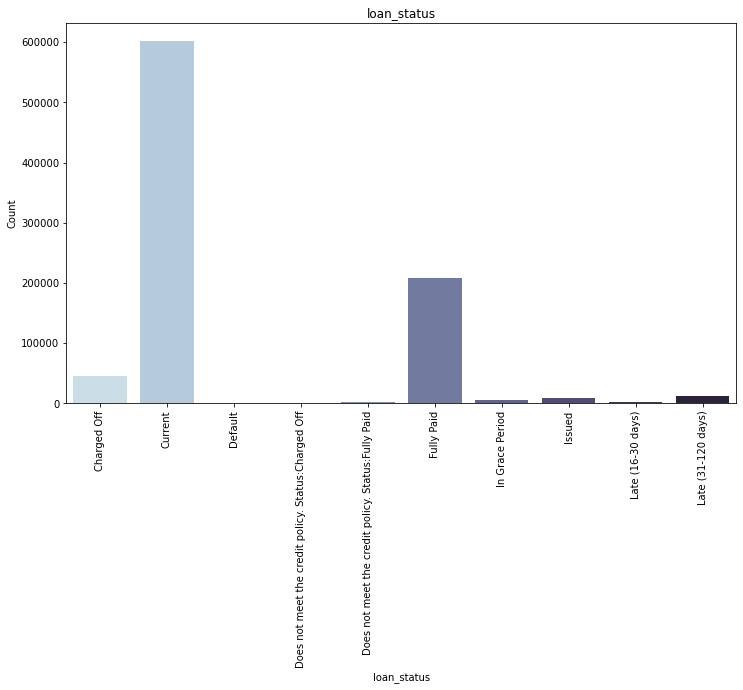

In [28]:
eda(df['loan_status'])

Heatmap overlayed on top of a correlation matrix of all the numerical variables. No notable correlations except for ```funded_amnt``` vs ```loan_amnt``` which makes sense and means Lending Club generally funds the amount requested for approved loans.

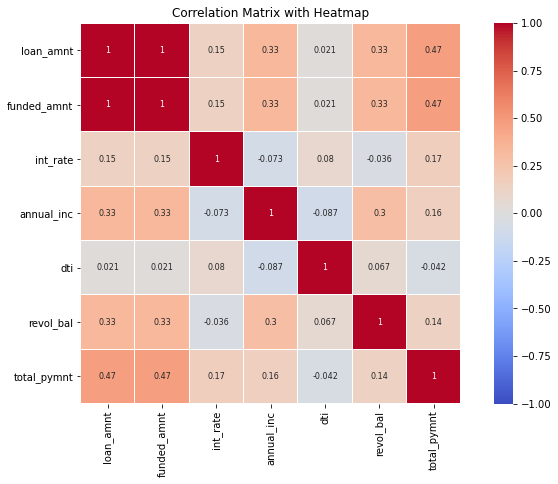

In [29]:
corr = df.corr()

plt.figure(figsize=(12,7))
sns.heatmap(corr, cmap='coolwarm', vmax=1, vmin=-1, linewidths=0.1, annot=True, annot_kws={'size': 8}, square=True)
plt.title('Correlation Matrix with Heatmap')
plt.show()

Scatterplot of loan amount against interest rate, with partitions by grade and status. From this plot, we can see the interest rates loans receive is generally bucketed based on the loan grade. It seems that regardless of loan grade, loan amounts can be up to the \\$35,000 max. A bit less apparent is the incidents of default increasing as the loan downgrades.

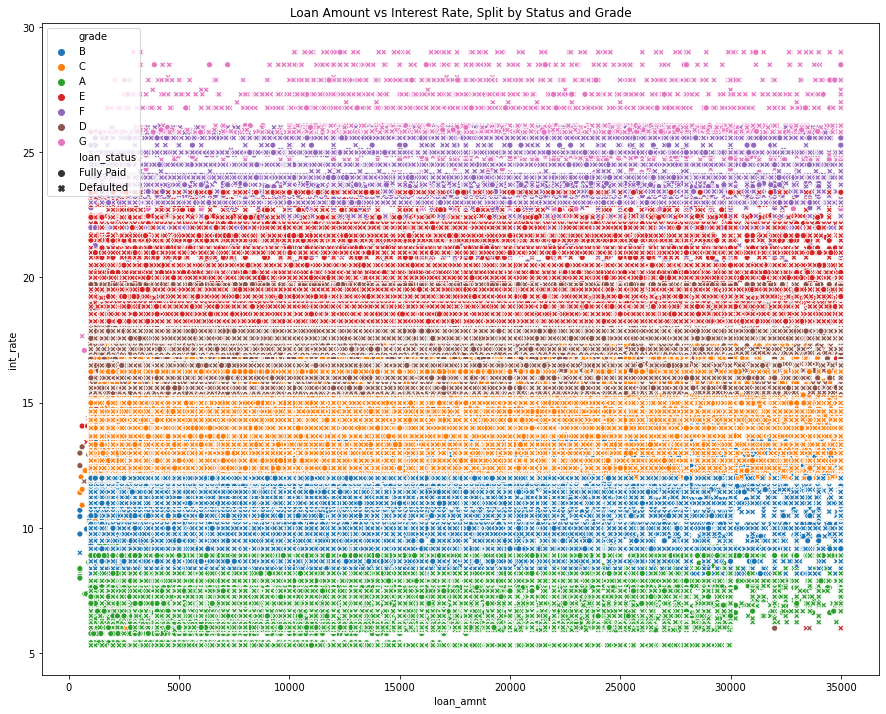

In [30]:
plt.figure(figsize=(15,12))
sns.scatterplot(x=df['loan_amnt'], 
                y=df['int_rate'], 
                hue=df['grade'], 
                style=df['loan_status'].map(lambda x: 'Fully Paid' if 'fully paid' in x.lower() else 'Defaulted'))
plt.title('Loan Amount vs Interest Rate, Split by Status and Grade')
plt.show()

Re-examining missing values. There are only 4 missing ```annual_inc``` values (amoung 887379 rows of data). Looking more closely at these four rows, I don't see any apparent reason why they are missing ```annual_inc``` values. Missing data handling (as well as persisted variable transformations) will be addressed later in the notebook.

In [31]:
df.isna().sum()

loan_amnt      0
funded_amnt    0
term           0
int_rate       0
grade          0
annual_inc     4
issue_d        0
loan_status    0
dti            0
revol_bal      0
total_pymnt    0
dtype: int64

In [32]:
df[df.isna().any(axis=1)]

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
42449,5000.0,5000.0,36 months,7.43,A,NaN,2007-08-01,Does not meet the credit policy. Status:Fully ...,1.0,0.0,5593.46
42450,7000.0,7000.0,36 months,7.75,A,NaN,2007-08-01,Does not meet the credit policy. Status:Fully ...,1.0,0.0,7867.53
42480,6700.0,6700.0,36 months,7.75,A,NaN,2007-07-01,Does not meet the credit policy. Status:Fully ...,1.0,0.0,7530.42
42533,6500.0,6500.0,36 months,8.38,A,NaN,2007-06-01,Does not meet the credit policy. Status:Fully ...,4.0,0.0,7373.83


## Calculating various metrics

In [33]:
# Keep only loans with a 36 month term that were issued at least 36 months before EOY 2015
# EOY in this case defined as the first day of December
df_36_mo = df[(df['term'] == ' 36 months') &
              (df['issue_d'].map(lambda x: x + relativedelta(months=+36)) <= datetime(2015, 12, 1))]
df_36_mo.describe(include='all')

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
count,75004.000000,75004.000000,75004,75004.000000,75004,7.500000e+04,75004,75004,75004.000000,7.500400e+04,75004.000000
unique,NaN,NaN,1,NaN,7,NaN,67,9,NaN,NaN,NaN
top,NaN,NaN,36 months,NaN,B,NaN,2012-10-01 00:00:00,Fully Paid,NaN,NaN,NaN
freq,NaN,NaN,75004,NaN,26469,NaN,5202,63357,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,2007-06-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2012-12-01 00:00:00,NaN,NaN,NaN,NaN
mean,10778.257826,10723.536745,NaN,12.037718,NaN,6.726583e+04,NaN,NaN,15.013122,1.402502e+04,11740.957596
std,6851.673213,6823.655100,NaN,3.648870,NaN,6.195099e+04,NaN,NaN,7.447380,1.853212e+04,8175.841664
min,500.000000,500.000000,NaN,5.420000,NaN,1.896000e+03,NaN,NaN,0.000000,0.000000e+00,0.000000
25%,6000.000000,5975.000000,NaN,8.900000,NaN,4.000000e+04,NaN,NaN,9.380000,5.028000e+03,5804.942512


### 1)

In [34]:
# Get count of all fully paid loans and divide by the total count
# Fully paid includes the status 'Does not meet the credit policy. Status:Fully Paid'
num_fully_paid_loans = len(df_36_mo[df_36_mo['loan_status'].map(lambda x: 'fully paid' in x.lower())])
perc_fully_paid_loans = num_fully_paid_loans / df_36_mo.shape[0]

print(f'Percentage of loans fully paid (including loans that don\'t meet the credit policy): {round(perc_fully_paid_loans*100, 2)}%')

Percentage of loans fully paid (including loans that don't meet the credit policy): 86.86%


### 2)

In [35]:
# Add issue year and defaulted (1 or 0) to dataframe
df_36_mo['issue_y'] = df_36_mo['issue_d'].dt.year
df_36_mo['defaulted'] = df_36_mo['loan_status'].map(lambda x: 0 if 'fully paid' in x.lower() else 1)

# Group by year of origination then grade, aggregate up the defaulted column into percentage defaulted
# and find the max group
default_rates_df = df_36_mo.groupby(['issue_y', 'grade'], as_index=False).agg(lambda x: x.sum() / x.count())
max_rate = default_rates_df[default_rates_df['defaulted'] == default_rates_df['defaulted'].max()].iloc[0]
print(f'The cohort with the highest rate of defaults is {max_rate.grade} in {max_rate.issue_y} with a rate of {round(max_rate.defaulted*100,2)}%')

The cohort with the highest rate of defaults is G in 2007 with a rate of 48.57%


### 3)

In [36]:
# Get annualized rate of return (do not subtract 1 yet)
df_36_mo['ann_rate_of_ret'] = (df_36_mo['total_pymnt'] / df_36_mo['funded_amnt']) ** (1/3)

# Average annualized rate of return bucketed by year of origination and grade
# Average here is calculated as the geometric mean given these are return streams
df_36_mo.groupby(['issue_y', 'grade'], as_index=False).agg(lambda x: x.prod() ** (1/x.count()) - 1)[['issue_y', 'grade', 'ann_rate_of_ret']]

,issue_y,grade,ann_rate_of_ret
0,2007,A,0.026704
1,2007,B,-0.013482
2,2007,C,-0.018493
3,2007,D,-0.025128
4,2007,E,-0.027891
5,2007,F,-0.101230
6,2007,G,-0.060272
7,2008,A,0.021194
8,2008,B,-1.000000
9,2008,C,-0.017277


## Modeling

Columns excluded from the set of independent variables include:
<br>
\-```loan_status```: will be set as the dependent variable
<br>
\-```term```: has no variation given we're only considering 36 month term loans
<br>
\-```issue_d```: this is defined as the month in which the loan was funded and disbursement of funds occurs post origination
<br>
\-```funded_amnt```: as mentioned, disbursement of funds occurs post origination. Additionally, this variable is nearly perfectly collinear with ```loan_amnt```
<br>
\-```total_pymnt```: repayment of the loan occurs after origination
<br><br>
Note, while ```loan_amnt``` may change if the credit department reduces the loan amount later, I am keeping this variable in my analysis and essentially assuming these revisions did not happen (I believe revisions happened rarely given the similarity between ```loan_amnt``` and ```funded_amnt```).

In [37]:
x_cols = ['loan_amnt', 'int_rate', 'grade', 'annual_inc', 'dti', 'revol_bal']
y_col = ['loan_status']

# Get the relevant dataset
df_all = df_36_mo[x_cols + y_col]

# Checking for missing values
df_all.isna().sum()

loan_amnt      0
int_rate       0
grade          0
annual_inc     4
dti            0
revol_bal      0
loan_status    0
dtype: int64

In [38]:
# Set defaulted = 1 and fully paid = 0 as defined in question 2
df_all['loan_status'] = df_all['loan_status'].map(lambda x: 0 if 'fully paid' in x.lower() else 1)

Before transforming ```grade```, look at how the different grades relate to the proportion of defaulted loans. The results make sense - there is an ordering among ```grade``` and higher grade loans are less likely to default. 
<br><br>
I will transform this variable into an ordinal one given the inherent ordering between different grades. I also considered keeping this variable categorical (through methods like one-hot/dummy variable encoding) because ordinal variables also imply the jump from one level to the next is the same regardless of which level (i.e. B to A is the same as E to D) but chose to represent this as an ordinal variable because I prioritized representing the data in an ordered fashion.

In [39]:
df_defaults_by_grade = df_all.groupby('grade', as_index=False).agg(lambda x: x.sum() / x.count())[['grade','loan_status']]
df_defaults_by_grade.columns = ['grade', 'proportion_defaulted']
df_defaults_by_grade

,grade,proportion_defaulted
0,A,0.066202
1,B,0.121123
2,C,0.169232
3,D,0.205886
4,E,0.225668
5,F,0.290698
6,G,0.340164


A logistic regression doesn't require any distribution for the independent variable values but I still applied a ```log(x + 1)``` transformation to ```annual_inc```, ```dti```, and ```revol_bal``` because I believe this better represented the nature of the data, handled most of the outliers, and helps with interpretability of the final model. I specifically used this version of the Box-Cox transformation so that 0 maps to 0. The small proportions of 0's for these variables also meant I wouldn't pursue something like a mixture model to address the 0's.

In [40]:
# Convert grade to ordinal variable where A = 0 and G = 6
df_all['grade'] = df_all['grade'].map(lambda x: ord(x) - ord('A'))

# Apply log(x + 1) transformation
for col in ['annual_inc', 'dti', 'revol_bal']:
    df_all[col] = np.log(df[col].map(lambda x: x + 1))
    df_all = df_all.rename(columns={col: f'log({col}+1)'})

In [41]:
# Partition into dependent and independent variables
y = df_all[y_col]
X = df_all.drop(y_col, axis=1)
X.head(5)

,loan_amnt,int_rate,grade,log(annual_inc+1),log(dti+1),log(revol_bal+1)
0,5000.0,10.65,1,10.085851,3.355153,9.521422
2,2400.0,15.96,2,9.413526,2.274186,7.991931
3,10000.0,13.49,2,10.803669,3.044522,8.630343
5,5000.0,7.90,0,10.491302,2.501436,8.982687
7,3000.0,18.64,4,10.778977,1.848455,9.014569


The four missing values in ```annual_inc``` still need to be addressed. Looking at those four specific rows, there weren't any obvious default values that were implied by a missing income value. Additionally, there was no available data on total monthly debt payments so ```annual_inc``` couldn't be imputed from ```dti = total monthly debt payments / monthly income```. As a result, I chose to impute using the 5-nearest neighbors. No ```is_missing``` indicator was included as this was only applied to 4 observations

In [42]:
# Imputation (and other processing) done after test/train split to avoid information leakage
imputer = KNNImputer(n_neighbors=5, 
                     weights='uniform', 
                     metric='nan_euclidean', 
                     add_indicator=False)

X_imputed = pd.DataFrame(imputer.fit_transform(X), index=X.index, columns=X.columns)
X_imputed[X.isna().any(axis=1)]

,loan_amnt,int_rate,grade,log(annual_inc+1),log(dti+1),log(revol_bal+1)
42449,5000.0,7.43,0.0,10.654186,0.693147,0.0
42450,7000.0,7.75,0.0,10.772792,0.693147,0.0
42480,6700.0,7.75,0.0,10.846094,0.693147,0.0
42533,6500.0,8.38,0.0,10.557297,1.609438,0.0


Using a stratified training and testing split because imbalance in the response variable.

In [43]:
print(f'Proportion of defaults: {round(len(y[y.loan_status == 1]) / y.shape[0], 2)}')

Proportion of defaults: 0.13


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

print(f'Proportion of defaults in train: {round(len(y_train[y_train.loan_status == 1]) / y_train.shape[0], 2)}')
print(f'Proportion of defaults in test: {round(len(y_test[y_test.loan_status == 1]) / y_test.shape[0], 2)}')

Proportion of defaults in train: 0.13
Proportion of defaults in test: 0.13


I use regularization to quickly and automatically perform variable selection. I specifically consider a combination of ```l1``` and ```l2``` regularization which I tune through a grid search. Hyperparameter tuning is set to optimize the $F$-score with $\beta=2$. This metric was chosen because:
<br><br>
\-There is imbalance in the response variable so the metric must account for that.
<br>
\-$F$-scores take into account both true positives and false negatives, both of which are especially important when trying to detect loan defaults (a loan default is much more costly than a missed loan opportunity). Furthermore, true negatives aren't included in this score and in this case represent the least costly scenario.
<br>
\-Because a high recall is more important than high precision, recall is emphasized in the $F$-score by setting $\beta=2$.
<br><br>
$\beta$ was specifically chosen to be 2 based on heuristics. However, it would be interesting to design a custom error function for this application by averaging the number of incidences of true negatives, false negatives, true positives, and false positives, weighted by the financial cost of each scenario.
<br><br>
The model itself was trained and validated as part of the grid search process, with 5-fold cross-validation performed at each grid node.

In [45]:
model = LogisticRegression(fit_intercept=True)

C = np.logspace(-4, 4, num=10, base=1).tolist()
l1_ratio = np.linspace(0, 1, 10).tolist()
scoring = make_scorer(fbeta_score, beta=2)

param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear'], 'C': C},
    {'penalty': ['l2'], 'solver': ['lbfgs'], 'C': C},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': C, 'l1_ratio': l1_ratio}
]

# Cross validation to test fitted models against out-of-sample data separate from the reserved test set
clf = GridSearchCV(model, 
                   param_grid, 
                   scoring=scoring, 
                   n_jobs=-1, 
                   cv=5, 
                   refit=True).fit(X_train, y_train.values.ravel())

print('GridSearchCV completed')

GridSearchCV completed


Final model parameters.

In [46]:
clf.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}

In [47]:
print('Coefficients:')

for name, coef in zip(X_train.columns.to_list(), clf.best_estimator_.coef_[0, :]):
    print(f'{name}: {coef}')
    
print(f'intercept: {clf.best_estimator_.intercept_[0]}')

Coefficients:
loan_amnt: 5.616768418370656e-07
int_rate: 0.10443027409045276
grade: 0.07209921261303537
log(annual_inc+1): -0.1950058226474044
log(dti+1): -0.02780066962809542
log(revol_bal+1): -0.12306416714748004
intercept: -0.017066418098191212


Calculating the optimum decision threshold based on the ROC curve.

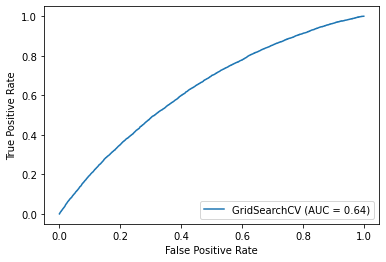

In [48]:
roc_curve_plot = plot_roc_curve(clf, X_train, y_train)

In [49]:
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])

# Get optimum threshold based on J statistic
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print(f'Best threshold = {round(best_thresh, 3)}')

Best threshold = 0.128


Using the updated decision threshold, the model's in-sample performance was poor.

In [50]:
y_train_pred = np.vectorize(lambda x: 1 if x >= best_thresh else 0)(clf.predict_proba(X_train)[:, 1])

In [51]:
print('Train data metrics')
print(f'Accuracy: {round(accuracy_score(y_train, y_train_pred), 4)}')
print(f'Precision: {round(precision_score(y_train, y_train_pred), 4)}')
print(f'Recall: {round(recall_score(y_train, y_train_pred), 4)}')
print(f'F1: {round(f1_score(y_train, y_train_pred), 4)}')
print(f'F2: {round(fbeta_score(y_train, y_train_pred, beta=2), 4)}')
print(f'ROC_AUC: {round(roc_auc_score(y_train, y_train_pred), 4)}')

Train data metrics
Accuracy: 0.5798
Precision: 0.1823
Recall: 0.6304
F1: 0.2828
F2: 0.4226
ROC_AUC: 0.6013


The model's out-of-sample performance was poor as well and not effective.
<br><br>
\-Accuracy was around 50%, which would be outperformed by a naive model given the data imbalance
<br>
\-The model has very poor precision and therefore is mostly incorrect about the loans it categorizes as defaulting
<br>
\-The best metric in terms of performance is recall although it is still not good - (it doesn't correctly categorize enough of the loans that actually default)
<br>
\-The two F-scores are below 0.5
<br>
\-AUC for the ROC is poor

In [52]:
y_test_pred = np.vectorize(lambda x: 1 if x >= best_thresh else 0)(clf.predict_proba(X_test)[:, 1])

In [53]:
print('Test data metrics')
print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 4)}')
print(f'Precision: {round(precision_score(y_test, y_test_pred), 4)}')
print(f'Recall: {round(recall_score(y_test, y_test_pred), 4)}')
print(f'F1: {round(f1_score(y_test, y_test_pred), 4)}')
print(f'F2: {round(fbeta_score(y_test, y_test_pred, beta=2), 4)}')
print(f'ROC_AUC: {round(roc_auc_score(y_test, y_test_pred), 4)}')

Test data metrics
Accuracy: 0.5773
Precision: 0.1824
Recall: 0.6364
F1: 0.2836
F2: 0.4249
ROC_AUC: 0.6024
